- https://blog.briankitano.com/llama-from-scratch/
- https://github.com/Lightning-AI/lit-llama/blob/main/lit_llama/model.py
- https://github.com/facebookresearch/llama/blob/main/llama/model.py
- https://github.com/huggingface/transformers/blob/main/src/transformers/models/llama/modeling_llama.py
- https://github.com/Lightning-AI/lit-gpt/blob/main/lit_gpt/model.py

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from dataclasses import dataclass
from types import SimpleNamespace

import matplotlib.pyplot as plt

In [2]:
@dataclass
class Config:
    dim = 256
    hidden_dim = int(8*dim / 3)
    hidden_dim = hidden_dim + 256 - (hidden_dim % 256) # make it multiple of 256
    n_heads = 8
    n_kv_heads = 4
    attn_bias = False
    max_pos_embeds = 256
    scaling_factor = 1.0

In [3]:
# TYPES

RoPECache = SimpleNamespace
KVCache = SimpleNamespace

In [4]:
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dim = config.dim
        self.hidden_dim = config.hidden_dim
        
        self.fc1 = nn.Linear(self.dim, self.hidden_dim, bias=False)
        self.fc2 = nn.Linear(self.dim, self.hidden_dim, bias=False)
        self.proj = nn.Linear(self.hidden_dim, self.dim, bias=False)
        
    def forward(self, x):
        x = F.silu(self.fc1(x)) * self.fc2(x)
        return self.proj(x)

### Root Mean Square Normalization

$$\bar{a}_i = \frac{a_i}{\text{RMS}(a)}g_i \\
\text{RMS}(a) = \sqrt{\frac{1}{n}\sum_{i=1}^{n}a_i^2}
$$

In [5]:
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.g = nn.Parameter(torch.ones(dim))
        self.eps = eps
        
    def _norm(self,x):
        ms = x.pow(2).mean(-1,keepdim=True) + self.eps # ms(a)
        return x * torch.rsqrt(ms) # 1/rms(a)
        
    def forward(self, x):
        x = self._norm(x.float()).to(dtype=x.dtype)
        return self.g * x

### Rotary Positional Embeddings (RoPE)

In [6]:
def build_rope_cache(
    rope_dim,
    max_seq_len,
    scaling_factor = 1.0,
    device = None
):
    # theta: (rope_dim//2,)
    i = torch.arange(0, rope_dim, 2).float() / rope_dim 
    theta = 1.0 / (10000 ** i) 
    theta = theta / scaling_factor
    theta.to(device)
    
    # indices: (max_seq_len,)
    indices = torch.arange(max_seq_len, device=device).float()
    
    # (max_seq_len, rope_dim//2)
    freqs = torch.outer(indices,theta)
    freqs = freqs.repeat(1,2) # (max_seq_len, rope_dim)
    
    return RoPECache(
        sin = freqs.sin(),
        cos = freqs.cos()
    )

def apply_rope(x, rope_cache):
    
    sin, cos = rope_cache.sin, rope_cache.cos
    
    half = x.size(-1) // 2 # rope_dim // 2
    x1 = x[...,:half]
    x2 = x[...,half:]
    rotated = torch.cat([-x2,x1],dim=-1) # B, nH, T, R ; R = H if rope fraction = 1.0 as in LLaMA
    xrope = (x * cos) + (rotated * sin)
    return xrope.type_as(x)

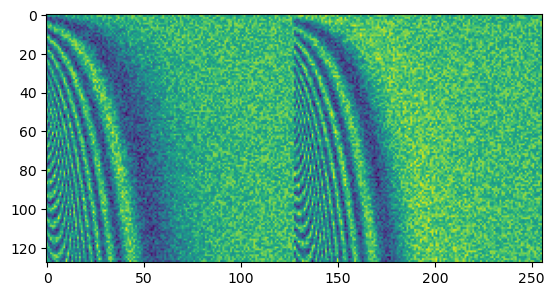

In [7]:
rope_cache = build_rope_cache(4096//16,128)
x = torch.rand(1,1,128,4096//16) # B,nH,T,R
o = apply_rope(x,rope_cache)
plt.imshow(o.squeeze())

In [36]:
rope_cache.sin.index_select(0,torch.tensor([8])).shape

torch.Size([1, 256])

# KV CACHE

In [25]:
class KVCache(nn.Module):
    def __init__(self, k_shape, v_shape, device, dtype):
        super().__init__()
        # persistent=False: do not save in state_dict
        self.register_buffer('k',torch.zeros(k_shape, device=device, dtype=dtype))
        self.register_buffer('v',torch.zeros(v_shape, device=device, dtype=dtype))
        
    def forward(self, input_pos, k, v):
        self.k = self.k.to(k)
        self.v = self.v.to(v)
        
        k = self.k.index_copy_(2, input_pos, k) # update in place
        v = self.v.index_copy_(2, input_pos, v)
        
        return k,v
    
    def reset_parameters(self,):
        nn.init.zeros_(self.k)
        nn.init.zeros_(self.v)

In [29]:
input_pos = torch.arange(8)
k = torch.rand(1,1,8,64)
v = torch.rand(1,1,8,64)
k_shape = (1,1,128+64,64) # b, nH, rope_cache_len + head_size, head_size
v_shape = (1,1,128,64) # b, nH, max_seq_len, head_size
kvc = KVCache(k_shape,v_shape,'cpu',torch.float32)

In [30]:
kvc.k.shape, kvc.v.shape

(torch.Size([1, 1, 192, 64]), torch.Size([1, 1, 128, 64]))

In [31]:
kc,vc = kvc(input_pos,k,v)

In [32]:
kc

tensor([[[[0.5967, 0.9886, 0.7494,  ..., 0.4305, 0.3209, 0.1692],
          [0.8736, 0.7404, 0.2286,  ..., 0.8409, 0.9482, 0.0634],
          [0.7200, 0.6027, 0.5337,  ..., 0.5857, 0.1296, 0.3206],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]])

### Causal Self Attention [YET TO ADD kv CACHE]

In [8]:
class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        self.dim = config.dim
        self.num_heads = config.num_heads
        self.head_dim = self.dim // self.num_heads
        self.scaling_factor = config.scaling_factor
        self.qkv_bias = config.qkv_bias
        
        self.q_proj = nn.Linear(self.dim,self.dim,bias=self.qkv_bias)
        self.k_proj = nn.Linear(self.dim,self.dim,bias=self.qkv_bias)
        self.v_proj = nn.Linear(self.dim,self.dim,bias=self.qkv_bias)
        self.o_proj = nn.Linear(self.dim,self.dim,bias=False)
        
        self.dropout = nn.Dropout(config.attention_dropout)
        
    def forward(self, x, position_ids, mask, rope_cache):
        
        B,T,C = x.shape
        
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)
        
        # B, nH, T, H
        q = q.reshape(B,T,self.num_heads,self.head_dim).permute(0,2,1,3)
        k = k.reshape(B,T,self.num_heads,self.head_dim).permute(0,2,1,3)
        v = v.reshape(B,T,self.num_heads,self.head_dim).permute(0,2,1,3)
        
        # apply rope
        q = apply_rope(q,rope_cache)
        k = apply_rope(k,rope_cache)
        
        attention = nn.functional.scaled_dot_product_attention(q,k,v,attn_mask = mask)
        attention = self.attention_dropout(attention)
        attention = attention.transpose(1,3).contiguous().view(B,T,C)
        
        return self.o_proj(attention)